# Data Science - ICARO
_________________________________
Clase: 13
Tema: Proyecto integrador - Supervisado
_________________________________


## Objetivo:
- Aplicar un flujo de trabajo de Machine Learning de principio a fin para resolver un problema de clasificación y uno de regresión, utilizando el dataset "Wine Quality".

---

## Índice

1. [Imports y Configuración Inicial](#imports)
2. [Carga y Preparación de Datos](#carga)
3. [Análisis Exploratorio de Datos (EDA)](#eda)
4. [**Tarea 1: Clasificación (Predecir Tipo de Vino)**](#clasificacion)
    - 4.1. [Preparación de Datos para Clasificación](#prep_clasificacion)
    - 4.2. [Modelos Base de Clasificación](#modelos_base_clasificacion)
    - 4.3. [**(A COMPLETAR) Modelos Avanzados y Optimización**](#completar_clasificacion)
    - 4.4. [**(A COMPLETAR) Tabla de Resultados y Conclusión de Clasificación**](#conclusion_clasificacion)
5. [**Tarea 2: Regresión (Predecir Calidad del Vino)**](#regresion)
    - 5.1. [Preparación de Datos para Regresión](#prep_regresion)
    - 5.2. [Modelo Base de Regresión](#modelo_base_regresion)
    - 5.3. [**(A COMPLETAR) Modelos Avanzados y Optimización**](#completar_regresion)
    - 5.4. [**(A COMPLETAR) Tabla de Resultados y Conclusión de Regresión**](#conclusion_regresion)
6. [**(A COMPLETAR) Conclusiones Finales del Proyecto**](#final)

---


<a name="imports"></a>
## 1. Imports y Configuración Inicial
En esta primera celda, importaremos todas las librerías que necesitaremos para nuestro análisis.

In [1]:
from time import time

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np

In [3]:
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Modelos y Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [5]:
# Métricas de evaluación
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score)

In [6]:
def highlight_best(row, row_index):
    if row.name == row_index:
        return ['background-color: lightgreen']*len(row)
    else:
        return ['']*len(row)

In [7]:
def evaluar_modelo(nombre_modelo, y_train_true, y_train_pred, y_test_true, y_test_pred, train_time,df_resultados, tipo_modelo= 'c', pos_label='white'):
    """
    Evalúa un modelo de clasificación o regresión, imprime métricas y guarda los resultados en un DataFrame.

    Parámetros
    ----------
    nombre_modelo : str
        Nombre del modelo (será el índice en df_resultados).
    tipo_modelo : str
        Tipo de modelo: 'c' = clasificación, 'r' = regresión.
    y_train_true, y_train_pred : array-like
        Valores verdaderos y predichos en entrenamiento.
    y_test_true, y_test_pred : array-like
        Valores verdaderos y predichos en prueba.
    train_time : float
        Tiempo de entrenamiento del modelo (en segundos).
    df_resultados : pd.DataFrame
        DataFrame donde se almacenarán las métricas.
    pos_label : str o int, opcional (default='white')
        Etiqueta considerada positiva para el cálculo de F1 (solo aplica a clasificación).

    Retorna
    --------
    df_resultados : pd.DataFrame
        DataFrame actualizado con las métricas del modelo.
    """

    # Validación del parámetro tipo_modelo
    tipo_modelo = tipo_modelo.lower()
    if tipo_modelo not in ['c', 'r']:
        raise ValueError("El parámetro 'tipo_modelo' debe ser 'c' (clasificación) o 'r' (regresión).")
    
    print(f"\n=== {nombre_modelo} ===")

    # Agregar tiempo de entrenamiento
    df_resultados.loc[nombre_modelo, 'train_time (s)'] = train_time

    # CASO 1: CLASIFICACIÓN
    if tipo_modelo.lower() == 'c':
        acc = accuracy_score(y_true=y_test_true, y_pred=y_test_pred)
        f1 = f1_score(y_true=y_test_true, y_pred=y_test_pred, pos_label=pos_label, average='weighted')
        
        # Guardar métricas en el DataFrame
        df_resultados.loc[nombre_modelo, 'accuracy'] = acc
        df_resultados.loc[nombre_modelo, 'f1_weighted'] = f1

        # Mostrar resultados
        print(f"Accuracy score: {acc:.4f}")
        print(f"F1-score (weighted): {f1:.4f}\n")

        print("---- Reporte de entrenamiento ----")
        print(classification_report(y_true=y_train_true, y_pred=y_train_pred))
        print("---- Reporte de prueba ----")
        print(classification_report(y_true=y_test_true, y_pred=y_test_pred))

    # CASO 2: REGRESIÓN
    elif tipo_modelo.lower() == 'r':
        mse = mean_squared_error(y_test_true, y_test_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_true, y_test_pred)

        # Guardar métricas en el DataFrame
        df_resultados.loc[nombre_modelo, 'RMSE'] = rmse
        df_resultados.loc[nombre_modelo, 'R2'] = r2

        # Mostrar resultados
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

    else:
        raise ValueError("El parámetro 'tipo_modelo' debe ser 'c' (clasificación) o 'r' (regresión).")

    print('-------------------------\n')

    return df_resultados

<a name="carga"></a>
## 2. Carga y Preparación de Datos
Vamos a cargar los dos datasets (vino tinto y vino blanco), añadiremos una columna para identificar el tipo de vino y luego los uniremos en un único DataFrame.

In [8]:
# URLs de los datasets
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Carga de los dataframes
df_red = pd.read_csv(url_red, sep=';')
df_white = pd.read_csv(url_white, sep=';')

In [9]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
# Creación de la columna 'type'
df_red['type'] = 'red'
df_white['type'] = 'white'

In [12]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [13]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [14]:
pd.concat([df_red, df_white], axis=0)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [15]:
# Unión de los dataframes
df = pd.concat([df_red, df_white], axis=0)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [16]:
df_white.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


In [17]:
# Reseteamos el índice
df.reset_index(drop=True, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [18]:
print("Forma del dataset combinado:", df.shape)
print("\nPrimeras 5 filas:")
display(df.head())

Forma del dataset combinado: (6497, 13)

Primeras 5 filas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


<a name="eda"></a>
## 3. Análisis Exploratorio de Datos (EDA)
Es fundamental entender nuestros datos antes de modelar. Realizaremos un análisis descriptivo y algunas visualizaciones clave.

In [19]:
# Información general y chequeo de nulos
print("Información del DataFrame:")
df.info()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [20]:
print("\nEstadísticas Descriptivas:")
display(df.describe())


Estadísticas Descriptivas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [21]:
df_white.shape

(4898, 13)

In [22]:
df_red.shape

(1599, 13)

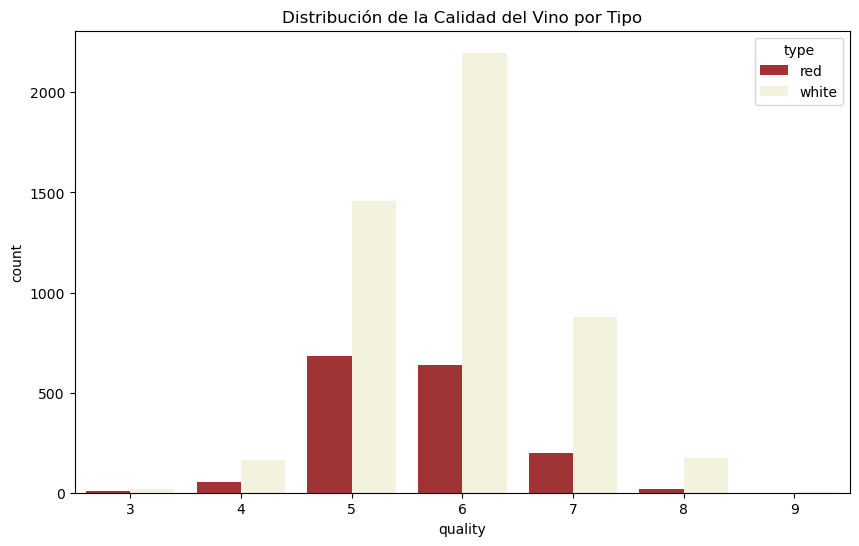

In [23]:
# Distribución de la variable 'quality' por tipo de vino
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='quality', hue='type', palette={'red': '#B22222', 'white': '#F5F5DC'})
plt.title('Distribución de la Calidad del Vino por Tipo')
plt.show()

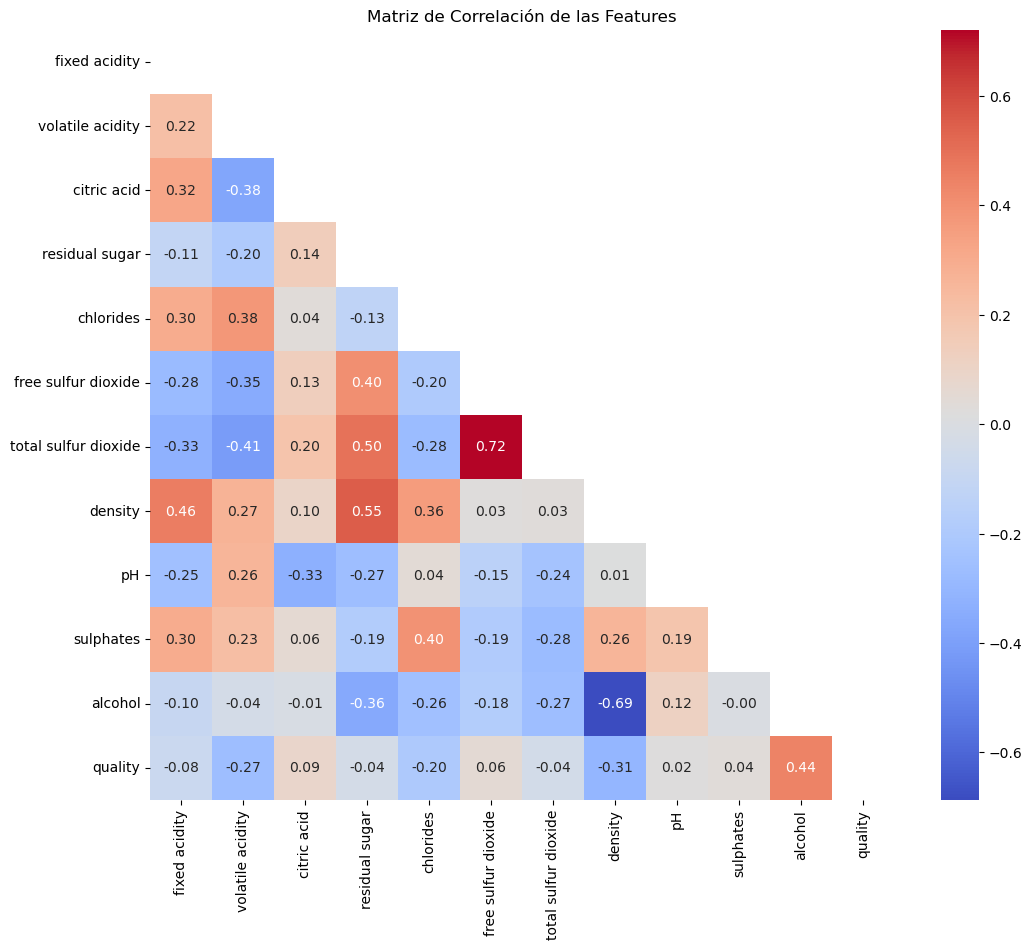

In [24]:
# Matriz de correlación de las variables fisicoquímicas
plt.figure(figsize=(12, 10))
# Excluimos la columna 'type' porque no es numérica
correlation_matrix = df.drop('type', axis=1).corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Matriz de Correlación de las Features')
plt.show()

### **(A COMPLETAR) Análisis del EDA**
*Observando las visualizaciones y estadísticas, respondan:*
- a. ¿Existen valores nulos en el dataset?
- b. ¿Qué variables parecen tener una mayor correlación (positiva o negativa) con la `quality`?
- c. ¿La distribución de la calidad es similar para vinos tintos y blancos? ¿Qué pueden decir de la distribución general de la calidad?

**Escriban sus respuestas aquí.**

a. ¿Existen valores nulos en el dataset?

In [25]:
nulos_por_columna = df.isnull().sum()

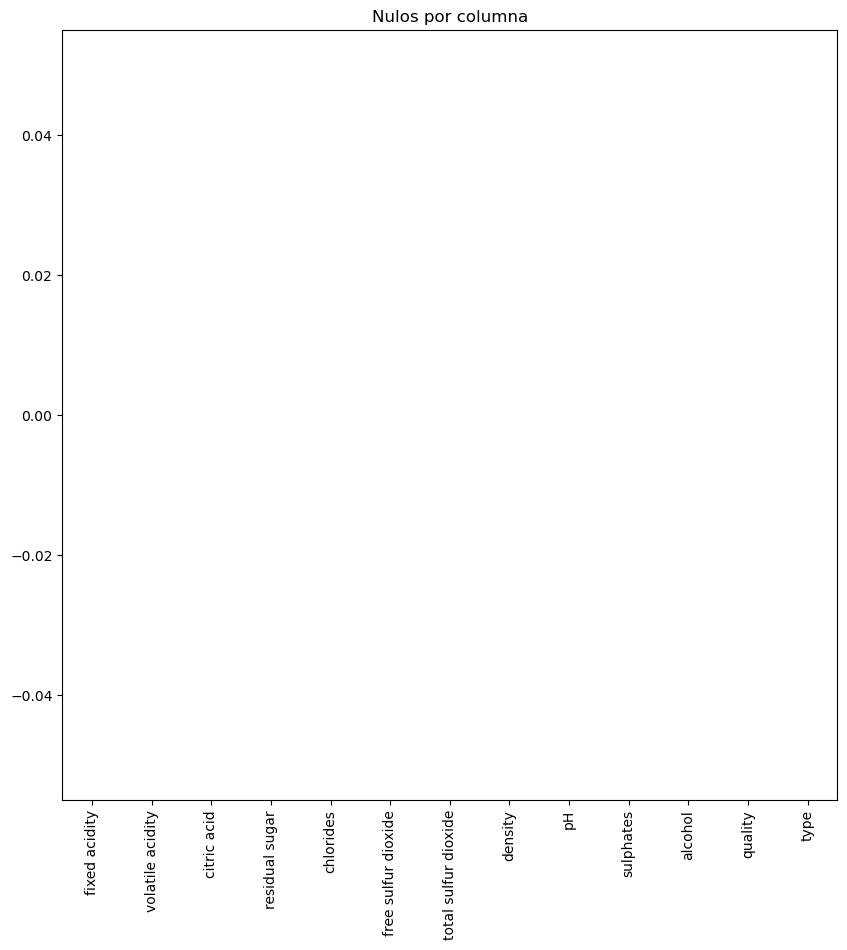

In [26]:
figure = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.title('Nulos por columna')
sns.barplot(nulos_por_columna)
plt.xticks(rotation=90)
plt.show()

<font color='green'>Respuesta: </font> En este conjunto de datos no hay precesencia de valores nulos explicitos en ninguna de las columnas.

b. ¿Qué variables parecen tener una mayor correlación (positiva o negativa) con la quality?

In [27]:
corr_matrix = df.corr(numeric_only=True)
corr_con_quality = corr_matrix['quality'].copy()
corr_con_quality = corr_con_quality.drop(index=['quality'])
corr_con_quality.sort_values(ascending=True, inplace=True, key=abs)

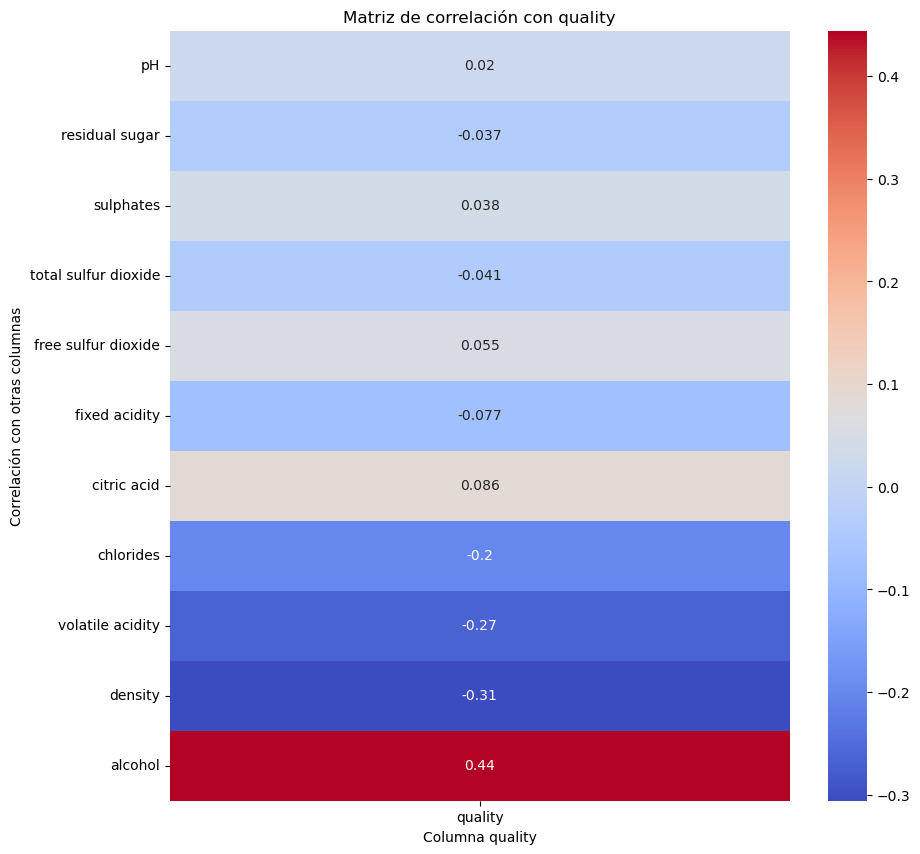

In [28]:
figure = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Matriz de correlación con quality')
sns.heatmap(corr_con_quality.to_frame(), cmap='coolwarm', annot=True)
plt.xlabel('Columna quality')
plt.ylabel('Correlación con otras columnas')
plt.show()

<font color='green'>Respuesta:</font>

Las tres variables que presentan mayor correlación lineal con la variable quality son:
1.	alcohol con una correlación positiva de 0.44,
2.	density con una correlación negativa de -0.31, y
3.	volatile acidity con una correlación negativa de -0.27.

Esto sugiere que a medida que aumenta el contenido de alcohol, la calidad del vino tiende a incrementarse, mientras que mayor densidad o acidez volátil se asocian con una menor calidad percibida. En conjunto, estas variables parecen aportar variabilidad relevante para explicar las diferencias en la puntuación de calidad.

c. ¿La distribución de la calidad es similar para vinos tintos y blancos? ¿Qué pueden decir de la distribución general de la calidad?

In [29]:
frecuencia_vinos = df['type'].value_counts(normalize=True)
frecuencia_vinos = frecuencia_vinos.round(2)

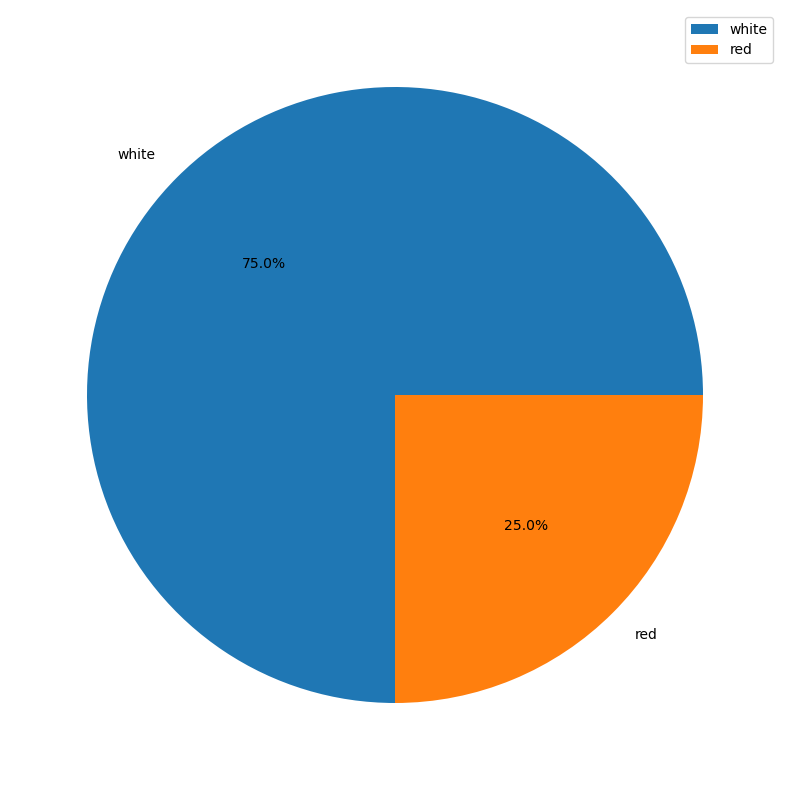

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.pie(frecuencia_vinos, labels= frecuencia_vinos.index, autopct="%1.1f%%")
plt.legend()
plt.show()

<font color='green'>Respuesta:</font> 

La distribución general de los vinos muestra una mayor proporción de vinos de tipo white, con una frecuencia relativa cercana al 75%, mientras que los vinos de tipo red representan el 25% restante.

En cuanto a la variable quality, la distribución de puntuaciones es en general similar entre ambos tipos de vino, con excepción de la puntuación 6, donde se observa una menor frecuencia en los vinos red y una mayor en los vinos white (en comparación con la puntuación 5).

Esto sugiere que la variable quality no aporta una diferenciación significativa entre los tipos de vino, sino que las diferencias observadas se deben principalmente a la disparidad en el número de registros por clase y no a una relación estructural entre tipo de vino y calidad.

<a name="clasificacion"></a>
## 4. Tarea 1: Clasificación (Predecir Tipo de Vino)
El objetivo aquí es construir un modelo que pueda identificar si un vino es tinto o blanco basándose en sus características fisicoquímicas.

In [31]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'DecisionTreeClassifierOpt', 'RandomForestClassifier', 'RandomForestClassifierOpt', 'XGBClassifier', 'XGBClassifierOpt']

In [32]:
columnas_rendimiento = ['train_time (s)', 'f1_weighted', 'accuracy']

In [33]:
type_modelos_clasificación_rendimiento = pd.DataFrame(
    columns=columnas_rendimiento,
    index=models
)

type_modelos_clasificación_rendimiento

,train_time (s),f1_weighted,accuracy
LogisticRegression,NaN,NaN,NaN
DecisionTreeClassifier,NaN,NaN,NaN
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


<a name="prep_clasificacion"></a>
### 4.1. Preparación de Datos para Clasificación
Definiremos nuestras variables `X` (features) e `y` (target), y luego dividiremos los datos y los escalaremos.

In [34]:
# Definición de Features (X) y Target (y)
X_clf = df.drop('type', axis=1)
y_clf = df['type']

In [35]:
# División en Train y Test (estratificada para mantener la proporción de clases)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf
)

In [36]:
# Escalar las features es crucial para muchos modelos
scaler_clf = StandardScaler()

X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

In [37]:
print("Forma de X_train escalado:", X_train_clf_scaled.shape)
print("Forma de X_test escalado:", X_test_clf_scaled.shape)

Forma de X_train escalado: (4872, 12)
Forma de X_test escalado: (1625, 12)


<a name="modelos_base_clasificacion"></a>
### 4.2. Modelos Base de Clasificación
Comenzamos con modelos simples para tener una línea de base (baseline) de rendimiento.

Modelo base 1: Regresión Logística

In [38]:
log_reg_classification_type = LogisticRegression(random_state=42, max_iter=1000)

In [39]:
log_reg_classification_type_init_train_time = time()
log_reg_classification_type.fit(X_train_clf_scaled, y_train_clf)
log_reg_classification_type_finish_train_time = time()
log_reg_classification_type_train_time = log_reg_classification_type_finish_train_time - log_reg_classification_type_init_train_time

In [40]:
log_reg_classification_type_train_preds = log_reg_classification_type.predict(X_train_clf_scaled)
log_reg_classification_type_test_preds = log_reg_classification_type.predict(X_test_clf_scaled)

In [41]:
evaluar_modelo(
    nombre_modelo='LogisticRegression',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=log_reg_classification_type_train_preds,
    y_test_true=y_test_clf,
    y_test_pred=log_reg_classification_type_test_preds,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=log_reg_classification_type_train_time
)


=== LogisticRegression ===
Accuracy score: 0.9914
F1-score (weighted): 0.9914

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       0.99      0.98      0.99      1199
       white       0.99      1.00      1.00      3673

    accuracy                           0.99      4872
   macro avg       0.99      0.99      0.99      4872
weighted avg       0.99      0.99      0.99      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.98      0.98      0.98       400
       white       0.99      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,NaN,NaN,NaN
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


Modelo base 2: Árbol de Decisión

In [42]:
type_dt_clf = DecisionTreeClassifier(random_state=42)

In [43]:
type_dt_clf_init_train_time = time()

type_dt_clf.fit(X_train_clf_scaled, y_train_clf)

type_dt_clf_finish_time = time()
type_dt_clf_train_time = type_dt_clf_finish_time - type_dt_clf_init_train_time

In [44]:
type_dt_clf_type_test_preds = type_dt_clf.predict(X_test_clf_scaled)
type_dt_clf_type_train_preds = type_dt_clf.predict(X_train_clf_scaled)

In [45]:
evaluar_modelo(
    nombre_modelo='DecisionTreeClassifier',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=type_dt_clf_type_train_preds,
    y_test_true=y_test_clf,
    y_test_pred=type_dt_clf_type_test_preds,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_dt_clf_train_time
)


=== DecisionTreeClassifier ===
Accuracy score: 0.9852
F1-score (weighted): 0.9853

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.96      0.98      0.97       400
       white       1.00      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.98      0.99      0.98      1625
weighted avg       0.99      0.99      0.99      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


<a name="completar_clasificacion"></a>
### 4.3. (A COMPLETAR) Modelos Avanzados y Optimización
Ahora es su turno. Deben entrenar un `RandomForestClassifier` y un `XGBClassifier`. Para ambos, utilicen `GridSearchCV` para encontrar los mejores hiperparámetros. Pueden utilizar las plantillas de las clases pasadas.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [48]:
from time import time

#### RandomForestClassifier

In [49]:
type_rf_clf = RandomForestClassifier(random_state=42)

In [50]:
type_rf_clf_init_time = time()

type_rf_clf.fit(X_train_clf_scaled, y_train_clf)

type_rf_clf_finish_time  = time()
type_rf_train_time = type_rf_clf_finish_time - type_rf_clf_init_time

In [51]:
type_rf_clf_train_pred = type_rf_clf.predict(X_train_clf_scaled)
type_rf_clf_test_pred = type_rf_clf.predict(X_test_clf_scaled)

In [52]:
evaluar_modelo(
    nombre_modelo='RandomForestClassifier',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=type_rf_clf_train_pred,
    y_test_true=y_test_clf,
    y_test_pred=type_rf_clf_test_pred,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_rf_train_time
)


=== RandomForestClassifier ===
Accuracy score: 0.9951
F1-score (weighted): 0.9951

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       1.00      1.00      1.00      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


#### RandomForestClassifier optimizado

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [53]:
rf_grid_param = {
    # Número de árboles en el bosque
    "n_estimators": [100, 300, 500, 1000],
    # Profundidad máxima de los árboles
    "max_depth": [None, 5, 10, 20, 50],
    # Número mínimo de muestras para dividir un nodo
    "min_samples_split": [2, 5, 10],
    # Número mínimo de muestras en una hoja
    "min_samples_leaf": [1, 2, 4, 10],
    # Número de características a considerar en cada división
    "max_features": ["sqrt", "log2", None],
    # Criterio de calidad de la división
    "criterion": ["gini", "entropy", "log_loss"]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [54]:
type_rf_opt_clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
        ),
    param_distributions=rf_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [55]:
type_rf_opt_clf_init_time = time()
type_rf_opt_clf.fit(X_train_clf_scaled, y_train_clf)
type_rf_opt_clf_finish_time  = time()
rf_opt_train_time = type_rf_opt_clf_finish_time - type_rf_opt_clf_init_time

4. Predicciones utilizando la instancia

In [56]:
type_rf_opt_clf_train_pred = type_rf_opt_clf.predict(X_train_clf_scaled)
type_rf_opt_clf_test_pred = type_rf_opt_clf.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [57]:
evaluar_modelo(
    nombre_modelo='RandomForestClassifierOpt',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=type_rf_opt_clf_train_pred,
    y_test_true=y_test_clf,
    y_test_pred=type_rf_opt_clf_test_pred,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=rf_opt_train_time
)


=== RandomForestClassifierOpt ===
Accuracy score: 0.9957
F1-score (weighted): 0.9957

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       1.00      0.99      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       1.00      1.00      1.00      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


#### XGBClassifier

Breve preprocesamiento de variables

In [58]:
xgb_oh_enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [59]:
xgb_oh_enc.fit(y_train_clf.to_frame())

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [60]:
y_train_clf_xgb = xgb_oh_enc.transform(y_train_clf.to_frame())
y_test_clf_xgb = xgb_oh_enc.transform(y_test_clf.to_frame())

Ml con XGBClassifier

In [61]:
type_xgb_clf = XGBClassifier()

In [62]:
type_xgb_clf_init_time = time()
type_xgb_clf.fit(X_train_clf_scaled, y_train_clf_xgb)
type_xgb_clf_finish_time = time()
type_xgb_clf_time = type_xgb_clf_finish_time - type_xgb_clf_init_time

In [63]:
type_xgb_clf_train_pred = type_xgb_clf.predict(X_train_clf_scaled)
type_xgb_clf_test_pred  = type_xgb_clf.predict(X_test_clf_scaled)

In [64]:
evaluar_modelo(
    nombre_modelo='XGBClassifier',
    tipo_modelo='c',
    y_train_true=y_train_clf_xgb,
    y_train_pred=type_xgb_clf_train_pred,
    y_test_true=y_test_clf_xgb,
    y_test_pred=type_xgb_clf_test_pred,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_xgb_clf_time,
    pos_label=1
)


=== XGBClassifier ===
Accuracy score: 0.9957
F1-score (weighted): 0.9957

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1199
         1.0       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       400
         1.0       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       0.99      1.00      0.99      1625
weighted avg       1.00      1.00      1.00      1625

-------------------------



,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,NaN,NaN,NaN


#### XGBClassifier optimizado

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [65]:
xgb_grid_param = {
    # Número de árboles (boosting rounds)
    "n_estimators": [100, 300, 500, 1000],
    # Tasa de aprendizaje
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    # Profundidad máxima del árbol
    "max_depth": [3, 5, 7, 10],
    # Número mínimo de muestras en una hoja
    "min_child_weight": [1, 3, 5, 10],
    # Gamma: reducción mínima de pérdida para hacer un split
    "gamma": [0, 0.1, 0.5, 1]
}

2. Instanciando `RandomSearchCV` con una instancia de `XGBClassifier`

In [66]:
type_xgb_opt_clf = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
        ),
    param_distributions=xgb_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [67]:
type_xgb_opt_clf_init_time = time()

type_xgb_opt_clf.fit(X_train_clf_scaled, y_train_clf_xgb)

type_xgb_opt_clf_final_time = time()
type_xgb_opt_clf_train_time = type_xgb_opt_clf_final_time - type_xgb_opt_clf_init_time

4. Predicciones utilizando la instancia

In [68]:
type_xgb_opt_clf_train_pred = type_xgb_opt_clf.predict(X_train_clf_scaled)
type_xgb_opt_clf_test_pred = type_xgb_opt_clf.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [69]:
evaluar_modelo(
    nombre_modelo='XGBClassifierOpt',
    tipo_modelo='c',
    y_train_true=y_train_clf_xgb,
    y_train_pred=type_xgb_opt_clf_train_pred,
    y_test_true=y_test_clf_xgb,
    y_test_pred=type_xgb_opt_clf_test_pred,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_xgb_opt_clf_train_time
)


=== XGBClassifierOpt ===
Accuracy score: 0.9969
F1-score (weighted): 0.9969

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1199
         1.0       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       400
         1.0       1.00      1.00      1.00      1225

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,NaN,NaN,NaN
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,9.272773,0.996924,0.996923


#### DecisionTreeClassifier optimizado

1. Definiendo grilla de hiperparámetros para `DecisionTreeClassifier` optimizado

In [70]:
param_grid_dt = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

2. Instanciando `GridSearchCV` con una instancia de `DecisionTreeClassifier` optimizado 

In [71]:
type_dt_opt_clf = GridSearchCV(
    estimator = DecisionTreeClassifier(
        random_state=42
    ),
    cv=3,
    param_grid=param_grid_dt,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

3. Entrenando la instancia de `GridSearchCV`

In [72]:
type_dt_opt_clf_init_time = time()

type_dt_opt_clf.fit(X_train_clf_scaled, y_train_clf)

type_dt_opt_clf_finish_time = time()
type_dt_opt_clf_time = type_dt_opt_clf_finish_time - type_dt_opt_clf_init_time

4. Predicciones utilizando la instancia

In [73]:
type_dt_opt_clf_train_pred = type_dt_opt_clf.predict(X_train_clf_scaled)
type_dt_opt_clf_test_pred = type_dt_opt_clf.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [74]:
evaluar_modelo(
    nombre_modelo='DecisionTreeClassifierOpt',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=type_dt_opt_clf_train_pred,
    y_test_true=y_test_clf,
    y_test_pred=type_dt_opt_clf_test_pred,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_dt_opt_clf_time
)


=== DecisionTreeClassifierOpt ===
Accuracy score: 0.9902
F1-score (weighted): 0.9901

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       1.00      1.00      1.00      1199
       white       1.00      1.00      1.00      3673

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.98      0.98      0.98       400
       white       0.99      0.99      0.99      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,17.013472,0.990146,0.990154
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,9.272773,0.996924,0.996923


#### LogisticRegression optimizado

1. Definiendo grilla de hiperparámetros para `LogisticRegression optimizado `

In [75]:
param_grid_logreg = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "saga"],
    "max_iter": [100, 500, 1000],
    "class_weight": [None, "balanced"]
}

2. Instanciando `GridSearchCV` con una instancia de `LogisticRegression optimizado `

In [76]:
type_log_reg_opt = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42
        ),
    param_grid=param_grid_logreg,
    cv=3,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

3. Entrenando la instancia de `GridSearchCV`

In [77]:
type_log_reg_opt_init_time = time()

type_log_reg_opt.fit(X_train_clf_scaled, y_train_clf)

type_log_reg_opt_finish_time = time()
type_log_reg_opt_time = type_log_reg_opt_finish_time - type_log_reg_opt_init_time

/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/

4. Predicciones utilizando la instancia

In [78]:
type_log_reg_opt_train_preds = type_log_reg_opt.predict(X_train_clf_scaled)
type_log_reg_opt_test_preds = type_log_reg_opt.predict(X_test_clf_scaled)

5. Evaluación utilizando la instancia

In [79]:
evaluar_modelo(
    nombre_modelo='LogisticRegressionOpt',
    tipo_modelo='c',
    y_train_true=y_train_clf,
    y_train_pred=type_log_reg_opt_train_preds,
    y_test_true=y_test_clf,
    y_test_pred=type_log_reg_opt_test_preds,
    df_resultados=type_modelos_clasificación_rendimiento,
    train_time=type_log_reg_opt_time
)


=== LogisticRegressionOpt ===
Accuracy score: 0.9945
F1-score (weighted): 0.9945

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         red       0.99      0.99      0.99      1199
       white       1.00      1.00      1.00      3673

    accuracy                           0.99      4872
   macro avg       0.99      0.99      0.99      4872
weighted avg       0.99      0.99      0.99      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         red       0.99      0.99      0.99       400
       white       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'white') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,17.013472,0.990146,0.990154
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,9.272773,0.996924,0.996923
LogisticRegressionOpt,40.269545,0.994464,0.994462


<a name="conclusion_clasificacion"></a>
### 4.4. (A COMPLETAR) Tabla de Resultados y Conclusión de Clasificación
Completen la siguiente tabla con los resultados obtenidos y escriban una conclusión clara.

In [80]:
type_modelos_clasificación_rendimiento = type_modelos_clasificación_rendimiento.round(2)

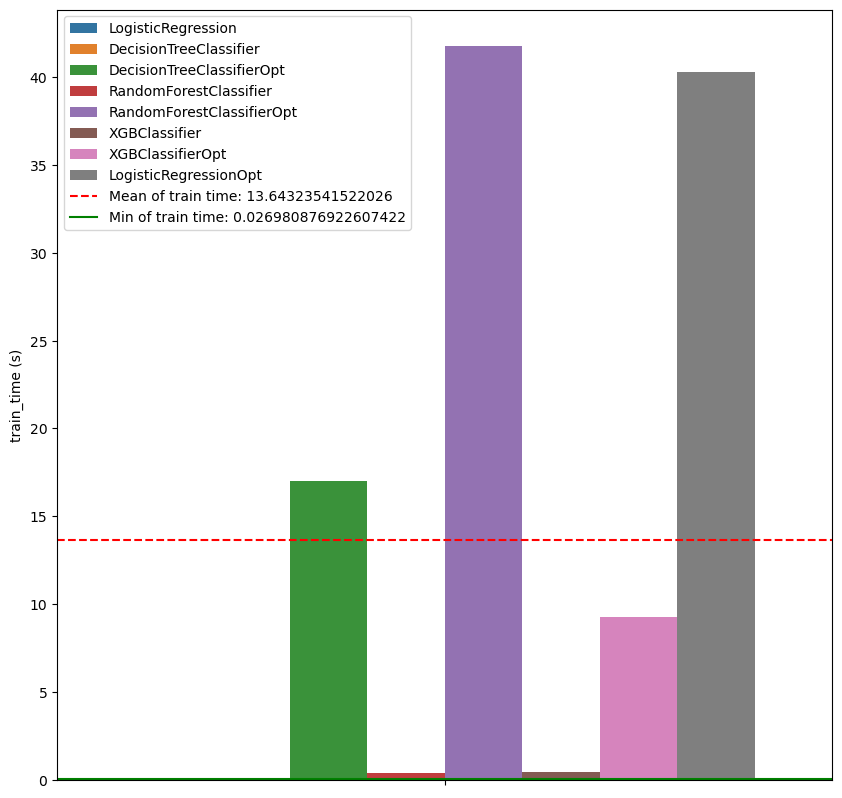

In [81]:
train_time_mean = type_modelos_clasificación_rendimiento['train_time (s)'].mean()
train_time_min = type_modelos_clasificación_rendimiento['train_time (s)'].min()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='train_time (s)', data=type_modelos_clasificación_rendimiento, ax=ax, hue=type_modelos_clasificación_rendimiento.index)
ax.axhline(train_time_mean, label=f'Mean of train time: {train_time_mean}', c='red', linestyle='--')
ax.axhline(train_time_min, label=f'Min of train time: {train_time_min}', c='green', linestyle='-')
ax.legend()

plt.show()

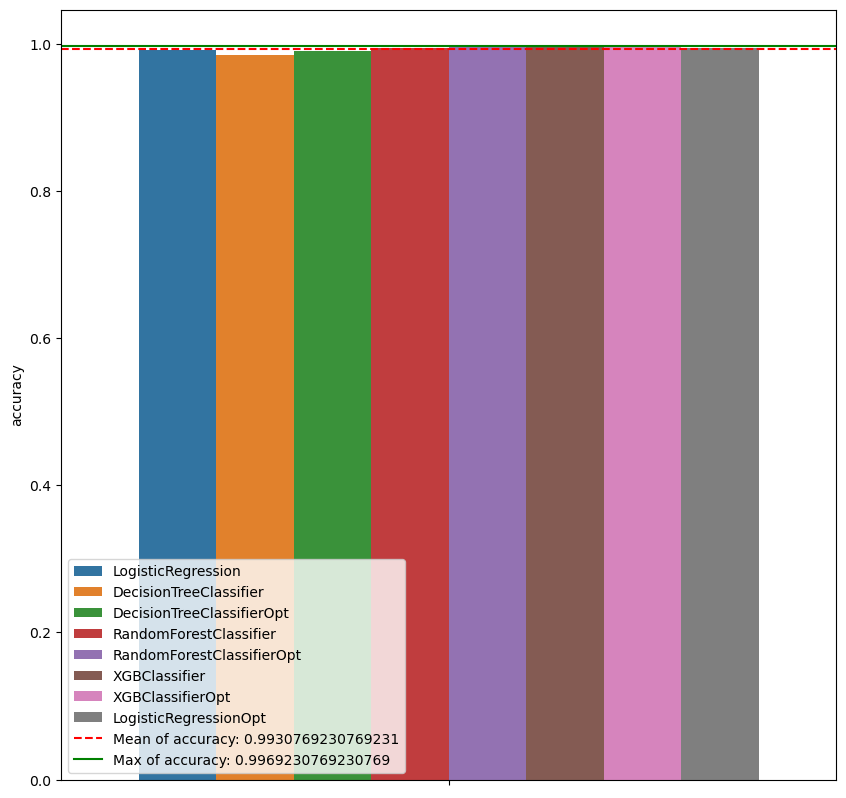

In [82]:
accuracy_mean = type_modelos_clasificación_rendimiento['accuracy'].mean()
accuracy_max = type_modelos_clasificación_rendimiento['accuracy'].max()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='accuracy', data=type_modelos_clasificación_rendimiento, ax=ax, hue=type_modelos_clasificación_rendimiento.index)
ax.axhline(accuracy_mean, label=f'Mean of accuracy: {accuracy_mean}', c='red', linestyle='--')
ax.axhline(accuracy_max, label=f'Max of accuracy: {accuracy_max}', c='green', linestyle='-')

ax.legend()
plt.show()

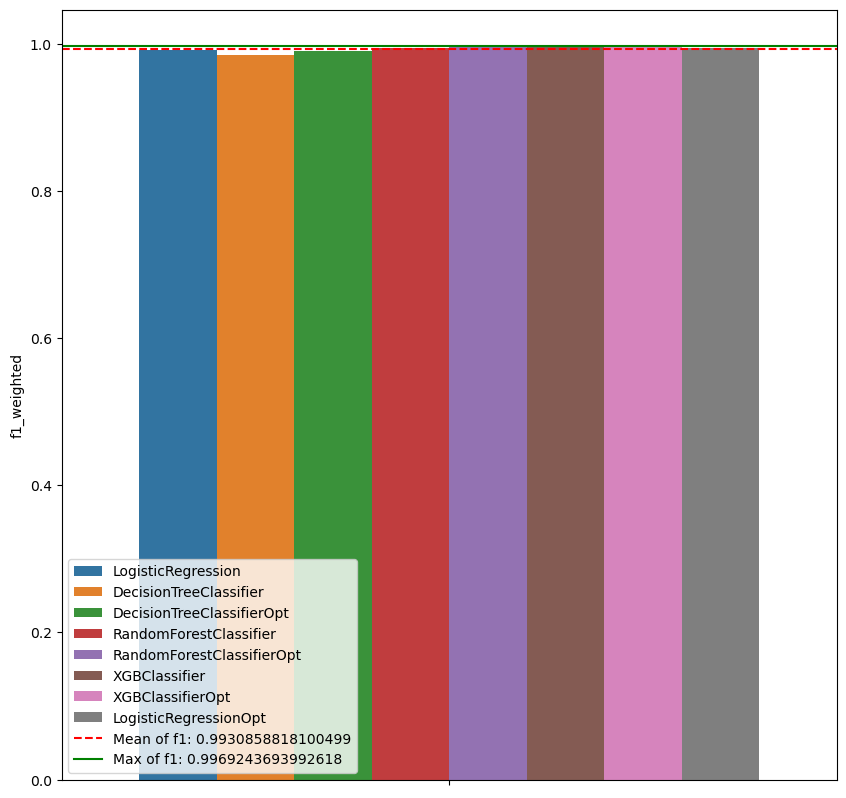

In [83]:
f1_mean = type_modelos_clasificación_rendimiento['f1_weighted'].mean()
f1_max = type_modelos_clasificación_rendimiento['f1_weighted'].max()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='f1_weighted', data=type_modelos_clasificación_rendimiento, ax=ax, hue=type_modelos_clasificación_rendimiento.index)
ax.axhline(accuracy_mean, label=f'Mean of f1: {f1_mean}', c='red', linestyle='--')
ax.axhline(accuracy_max, label=f'Max of f1: {f1_max}', c='green', linestyle='-')

ax.legend()
plt.show()

In [84]:
type_modelos_clasificación_rendimiento

,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,17.013472,0.990146,0.990154
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.99569,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,9.272773,0.996924,0.996923
LogisticRegressionOpt,40.269545,0.994464,0.994462


In [85]:
mask_type_modelos_clasificación_rendimiento = (
    (type_modelos_clasificación_rendimiento['f1_weighted'] >= type_modelos_clasificación_rendimiento['f1_weighted'].quantile(0.90)) &
    (type_modelos_clasificación_rendimiento['accuracy'] >= type_modelos_clasificación_rendimiento['accuracy'].quantile(0.90)) &
    (type_modelos_clasificación_rendimiento['train_time (s)'] < type_modelos_clasificación_rendimiento['train_time (s)'].quantile(0.50))
)

type_modelos_clasificación_rendimiento_filtrado = type_modelos_clasificación_rendimiento[mask_type_modelos_clasificación_rendimiento]
type_modelos_clasificación_rendimiento_filtrado

,train_time (s),f1_weighted,accuracy


In [139]:
row_index = 'XGBClassifier'

# Aplicar estilo
type_modelos_clasificación_rendimiento.style.apply(highlight_best, axis=1, row_index=row_index)

,train_time (s),f1_weighted,accuracy
LogisticRegression,0.026981,0.991385,0.991385
DecisionTreeClassifier,0.032411,0.985304,0.985231
DecisionTreeClassifierOpt,17.013472,0.990146,0.990154
RandomForestClassifier,0.357099,0.995077,0.995077
RandomForestClassifierOpt,41.767387,0.995690,0.995692
XGBClassifier,0.406215,0.995698,0.995692
XGBClassifierOpt,9.272773,0.996924,0.996923
LogisticRegressionOpt,40.269545,0.994464,0.994462


Deberán completar la siguiente tabla:

| Modelo                     | train_time (s) | f1_weighted | accuracy |
|-----------------------------|----------------|--------------|-----------|
| LogisticRegression          | 0.026981       | 0.991385     | 0.991385  |
| DecisionTreeClassifier      | 0.032411       | 0.985304     | 0.985231  |
| DecisionTreeClassifierOpt   | 17.013472      | 0.990146     | 0.990154  |
| RandomForestClassifier      | 0.357099       | 0.995077     | 0.995077  |
| RandomForestClassifierOpt   | 41.767387      | 0.995690     | 0.995692  |
| XGBClassifier               | 0.406215       | 0.995698     | 0.995692  |
| XGBClassifierOpt            | 9.272773       | 0.996924     | 0.996923  |
| LogisticRegressionOpt       | 40.269545      | 0.994464     | 0.994462  |
---

### Conclusión de la Tarea de Clasificación

**Escriban su conclusión aquí.**
*Basándose en las métricas, ¿qué modelo es el mejor para esta tarea? ¿Por qué? Consideren no solo la performance (Accuracy/F1-score) sino también otros factores como el tiempo de entrenamiento o la interpretabilidad.*

<font color='green'>Respuesta:</font>

El modelo que mostró el mejor equilibrio entre rendimiento, tiempo de entrenamiento e interpretabilidad fue el XGBClassifier en su configuración base, sin la aplicación de GridSearchCV. Este modelo logró una alta tasa de aciertos con un costo computacional moderado, lo que lo convierte en una opción sólida y eficiente para este tipo de tarea.

---

<a name="regresion"></a>
## 5. Tarea 2: Regresión (Predecir Calidad del Vino)
Ahora, el objetivo es predecir la puntuación de `quality` del vino.

<a name="prep_regresion"></a>
### 5.1. Preparación de Datos para Regresión

In [87]:
models = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor']

columnas_rendimiento = ['train_time (s)', 'RMSE', 'R2']

quality_modelos_regression_rendimiento = pd.DataFrame(
    columns=columnas_rendimiento,
    index=models
)

In [88]:
# Definición de Features (X) y Target (y)
# Usaremos las mismas features, pero sin 'type' y el target ahora es 'quality'
X_reg = df.drop(['type', 'quality'], axis=1)
y_reg = df['quality']

In [89]:
# División en Train y Test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

In [90]:
# Escalamiento de datos
scaler_reg = StandardScaler()

X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

<a name="modelo_base_regresion"></a>
### 5.2. Modelo Base de Regresión

Modelo base 1: Regresión Lineal

In [91]:
quality_lin_reg = LinearRegression()

In [92]:
quality_lin_reg_init_time = time()

quality_lin_reg.fit(X_train_reg_scaled, y_train_reg)

quality_lin_reg_finish_time = time()
quality_lin_reg_train_time = quality_lin_reg_finish_time - quality_lin_reg_init_time

In [93]:
y_test_pred_lin_reg = quality_lin_reg.predict(X_test_reg_scaled)
y_train_pred_lin_reg = quality_lin_reg.predict(X_train_reg_scaled)

In [94]:
evaluar_modelo(
    nombre_modelo= 'LinearRegression', 
    y_train_true= y_train_reg, 
    y_train_pred=y_train_pred_lin_reg, 
    y_test_true= y_test_reg, 
    y_test_pred=y_test_pred_lin_reg, 
    train_time=quality_lin_reg_train_time,
    df_resultados=quality_modelos_regression_rendimiento, 
    tipo_modelo= 'r'
    )


=== LinearRegression ===
Root Mean Squared Error (RMSE): 0.7421
R² Score: 0.2589
-------------------------



,train_time (s),RMSE,R2
LinearRegression,0.011314,0.742092,0.258879
DecisionTreeRegressor,NaN,NaN,NaN
RandomForestRegressor,NaN,NaN,NaN


Modelo base 2: Árbol de Decisión para Regresión

In [95]:
quality_tree_reg = DecisionTreeRegressor(max_depth = 3, random_state=42)

In [96]:
quality_tree_reg_init_time = time()

quality_tree_reg.fit(X_train_reg_scaled, y_train_reg)

quality_tree_reg_finish_time = time()
quality_tree_reg_train_time = quality_tree_reg_finish_time - quality_tree_reg_init_time

In [97]:
quality_y_pred_train_tree_reg = quality_tree_reg.predict(X_train_reg_scaled)
quality_y_pred_test_tree_reg = quality_tree_reg.predict(X_test_reg_scaled)

In [98]:
evaluar_modelo(
    nombre_modelo= 'DecisionTreeRegressor', 
    y_train_true= y_train_reg, 
    y_train_pred=quality_y_pred_train_tree_reg, 
    y_test_true=y_test_reg, 
    y_test_pred=quality_y_pred_test_tree_reg, 
    train_time=quality_lin_reg_train_time,
    df_resultados=quality_modelos_regression_rendimiento, 
    tipo_modelo= 'r'
    )


=== DecisionTreeRegressor ===
Root Mean Squared Error (RMSE): 0.7493
R² Score: 0.2444
-------------------------



,train_time (s),RMSE,R2
LinearRegression,0.011314,0.742092,0.258879
DecisionTreeRegressor,0.011314,0.749311,0.24439
RandomForestRegressor,NaN,NaN,NaN


Modelo base 3: RandomForest para Regresión

In [99]:
quality_rf_reg = RandomForestRegressor(max_depth = 3, random_state=42)

In [100]:
quality_rf_reg.fit(X_train_reg_scaled, y_train_reg)

RandomForestRegressor(max_depth=3, random_state=42)

In [101]:
y_pred_train_quality_rf_reg = quality_rf_reg.predict(X_train_reg_scaled)
y_pred_test_quality_rf_reg = quality_rf_reg.predict(X_test_reg_scaled)

In [102]:
evaluar_modelo(
    nombre_modelo= 'RandomForestRegressor', 
    y_train_true= y_train_reg, 
    y_train_pred=y_pred_train_quality_rf_reg, 
    y_test_true=y_test_reg, 
    y_test_pred=y_pred_test_quality_rf_reg, 
    train_time=quality_lin_reg_train_time,
    df_resultados=quality_modelos_regression_rendimiento, 
    tipo_modelo= 'r'
    )


=== RandomForestRegressor ===
Root Mean Squared Error (RMSE): 0.7386
R² Score: 0.2659
-------------------------



,train_time (s),RMSE,R2
LinearRegression,0.011314,0.742092,0.258879
DecisionTreeRegressor,0.011314,0.749311,0.24439
RandomForestRegressor,0.011314,0.738584,0.265869


<a name="completar_regresion"></a>
### 5.3. (A COMPLETAR) Modelos Avanzados y Optimización
Al igual que en la tarea de clasificación, deben implementar y optimizar los modelos `RandomForestRegressor` y `XGBRegressor`. Pueden utilizar las plantillas de las clases pasadas.

Convertimos el problema a uno de clasificación

In [103]:
models = ['DecisionTreeClassifierOpt', 'LogisticRegressionOpt', 'RandomForestClassifierOpt', 'XGBClassifierOpt']

columnas_rendimiento = ['train_time (s)', 'f1_weighted', 'accuracy']

quality_modelos_clasificacion_rendimiento = pd.DataFrame(
    columns=columnas_rendimiento,
    index=models
)

In [104]:
X_reg_clf = df.drop(columns=['quality']).copy()
y_reg_clf = df['quality']

In [105]:
X_reg_clf.drop(columns=['type'], inplace=True)

In [106]:
bad_quality_mask = y_reg_clf <= 5
good_quality_mask = y_reg_clf > 5

y_reg_clf[bad_quality_mask] = 'bad_quality'
y_reg_clf[good_quality_mask] = 'good_quality'

y_reg_clf.value_counts()

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_40875/2158738297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_reg_clf[bad_quality_mask] = 'bad_quality'
/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_40875/2158738297.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'bad_quality' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_reg_clf[bad_quality_mask] = 'bad_quality'


quality
good_quality    4113
bad_quality     2384
Name: count, dtype: int64

In [107]:
X_quality_train, X_quality_test, y_quality_train, y_quality_test = train_test_split(X_reg_clf, y_reg_clf, random_state=42, stratify=y_reg_clf)

DecisionTreeClassifier

In [108]:
param_grid_dt = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

In [109]:
d_tree_quality_opt = GridSearchCV(
    estimator = DecisionTreeClassifier(
        random_state=42
    ),
    cv=3,
    param_grid=param_grid_dt,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

In [110]:
d_tree_quality_opt_init_time = time()

d_tree_quality_opt.fit(X_quality_train, y_quality_train)

d_tree_quality_opt_final_time = time()
d_tree_quality_opt_time = d_tree_quality_opt_final_time - d_tree_quality_opt_init_time

In [111]:
d_tree_quality_opt_test_pred = d_tree_quality_opt.predict(X_quality_test)
d_tree_quality_opt_train_pred = d_tree_quality_opt.predict(X_quality_train)

In [112]:
evaluar_modelo(
    nombre_modelo= 'DecisionTreeClassifierOpt', 
    y_train_true= y_quality_train, 
    y_train_pred=d_tree_quality_opt_train_pred, 
    y_test_true=y_quality_test, 
    y_test_pred=d_tree_quality_opt_test_pred, 
    train_time=d_tree_quality_opt_time,
    df_resultados=quality_modelos_clasificacion_rendimiento, 
    tipo_modelo= 'c',
    pos_label='good_quality'
    )


=== DecisionTreeClassifierOpt ===
Accuracy score: 0.7483
F1-score (weighted): 0.7500

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

 bad_quality       0.93      0.97      0.95      1788
good_quality       0.98      0.96      0.97      3084

    accuracy                           0.96      4872
   macro avg       0.96      0.97      0.96      4872
weighted avg       0.97      0.96      0.96      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

 bad_quality       0.65      0.69      0.67       596
good_quality       0.81      0.78      0.80      1029

    accuracy                           0.75      1625
   macro avg       0.73      0.74      0.73      1625
weighted avg       0.75      0.75      0.75      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'good_quality') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
DecisionTreeClassifierOpt,21.459401,0.750004,0.748308
LogisticRegressionOpt,NaN,NaN,NaN
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


LogisticRegression

In [113]:
sc_x_quality = StandardScaler()

sc_x_quality.fit(X_quality_train)

X_quality_train_scaled = sc_x_quality.transform(X_quality_train)
X_quality_test_scaled = sc_x_quality.transform(X_quality_test)

In [114]:
param_grid_log_reg = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["lbfgs", "liblinear", "saga"],
    "max_iter": [100, 500, 1000],
    "class_weight": [None, "balanced"]
}

In [115]:
log_reg_opt = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42
        ),
    param_grid=param_grid_logreg,
    cv=3,
    scoring=['accuracy', 'f1_weighted'],
    refit = 'f1_weighted'
)

In [116]:
log_reg_opt_init_time = time()

log_reg_opt.fit(X_quality_train_scaled, y_quality_train)

log_reg_opt_finish_time = time()
log_reg_opt_time = log_reg_opt_finish_time - log_reg_opt_init_time

/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
630 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/data_science/lib/python3.12/sit

In [117]:
log_reg_quality_opt_train_preds = log_reg_opt.predict(X_quality_train)

/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [118]:
log_reg_quality_opt_test_preds = log_reg_opt.predict(X_quality_test)

/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [119]:
evaluar_modelo(
    nombre_modelo= 'LogisticRegressionOpt', 
    y_train_true= y_quality_train, 
    y_train_pred=log_reg_quality_opt_train_preds, 
    y_test_true=y_quality_test, 
    y_test_pred=log_reg_quality_opt_test_preds, 
    train_time=log_reg_opt_time,
    df_resultados=quality_modelos_clasificacion_rendimiento, 
    tipo_modelo= 'c',
    pos_label='good_quality'
    )

/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'good_quality') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(



=== LogisticRegressionOpt ===
Accuracy score: 0.4105
F1-score (weighted): 0.3402

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

 bad_quality       0.36      0.83      0.51      1788
good_quality       0.62      0.16      0.25      3084

    accuracy                           0.40      4872
   macro avg       0.49      0.49      0.38      4872
weighted avg       0.52      0.40      0.34      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

 bad_quality       0.37      0.87      0.52       596
good_quality       0.66      0.14      0.24      1029

    accuracy                           0.41      1625
   macro avg       0.51      0.51      0.38      1625
weighted avg       0.55      0.41      0.34      1625

-------------------------



,train_time (s),f1_weighted,accuracy
DecisionTreeClassifierOpt,21.459401,0.750004,0.748308
LogisticRegressionOpt,14.369754,0.340205,0.410462
RandomForestClassifierOpt,NaN,NaN,NaN
XGBClassifierOpt,NaN,NaN,NaN


RandomForestClassifier Optimizado sobre columna Quality

1. Definiendo grilla de hiperparámetros para `RandomForestClassifier`

In [120]:
rf_grid_param = {
    # Número de árboles en el bosque
    "n_estimators": [100, 300, 500, 1000],
    # Profundidad máxima de los árboles
    "max_depth": [None, 5, 10, 20, 50],
    # Número mínimo de muestras para dividir un nodo
    "min_samples_split": [2, 5, 10],
    # Número mínimo de muestras en una hoja
    "min_samples_leaf": [1, 2, 4, 10],
    # Número de características a considerar en cada división
    "max_features": ["sqrt", "log2", None],
    # Criterio de calidad de la división
    "criterion": ["gini", "entropy", "log_loss"]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [121]:
quality_rf_opt_clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
        ),
    param_distributions=rf_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [122]:
quality_rf_opt_clf_init_time = time()

quality_rf_opt_clf.fit(X_quality_train_scaled, y_quality_train)

quality_rf_opt_clf_final_time = time()
quality_rf_opt_clf_train_time = quality_rf_opt_clf_final_time - quality_rf_opt_clf_init_time

4. Predicciones utilizando la instancia

In [123]:
quality_rf_clf_opt_train_pred = quality_rf_opt_clf.predict(X_quality_train_scaled)
quality_rf_clf_opt_test_pred = quality_rf_opt_clf.predict(X_quality_test_scaled)

5. Evaluación utilizando la instancia

In [124]:
evaluar_modelo(
    nombre_modelo= 'RandomForestClassifierOpt', 
    y_train_true= y_quality_train, 
    y_train_pred=quality_rf_clf_opt_train_pred, 
    y_test_true=y_quality_test, 
    y_test_pred=quality_rf_clf_opt_test_pred, 
    train_time=quality_rf_opt_clf_train_time,
    df_resultados=quality_modelos_clasificacion_rendimiento, 
    tipo_modelo= 'c',
    pos_label='good_quality'
)


=== RandomForestClassifierOpt ===
Accuracy score: 0.8388
F1-score (weighted): 0.8365

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

 bad_quality       1.00      1.00      1.00      1788
good_quality       1.00      1.00      1.00      3084

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

 bad_quality       0.82      0.72      0.77       596
good_quality       0.85      0.91      0.88      1029

    accuracy                           0.84      1625
   macro avg       0.83      0.81      0.82      1625
weighted avg       0.84      0.84      0.84      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'good_quality') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
DecisionTreeClassifierOpt,21.459401,0.750004,0.748308
LogisticRegressionOpt,14.369754,0.340205,0.410462
RandomForestClassifierOpt,53.639851,0.836471,0.838769
XGBClassifierOpt,NaN,NaN,NaN


#### XGBClassifier optimizado para columna `quality`

In [125]:
xgb_oh_enc = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [126]:
xgb_oh_enc.fit(y_quality_train.to_frame())

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [127]:
y_quality_train_clf_xgb = xgb_oh_enc.transform(y_quality_train.to_frame())
y_quality_test_clf_xgb = xgb_oh_enc.transform(y_quality_test.to_frame())

1. Definiendo grilla de hiperparámetros para `XGBClassifier`

In [128]:
xgb_grid_param = {
    # Número de árboles (boosting rounds)
    "n_estimators": [100, 300, 500, 1000],
    # Tasa de aprendizaje
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    # Profundidad máxima del árbol
    "max_depth": [3, 5, 7, 10],
    # Número mínimo de muestras en una hoja
    "min_child_weight": [1, 3, 5, 10],
    # Gamma: reducción mínima de pérdida para hacer un split
    "gamma": [0, 0.1, 0.5, 1]
}

2. Instanciando `RandomSearchCV` con una instancia de `RandomForestClassifier`

In [129]:
quality_xgb_opt = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
        ),
    param_distributions=xgb_grid_param,
    scoring=['accuracy', 'f1_weighted'],
    cv = 3,
    refit = 'f1_weighted'
    )

3. Entrenando la instancia de `GridSearchCV`

In [130]:
quality_xgb_opt_init_time = time()

quality_xgb_opt.fit(X_quality_train_scaled, y_quality_train_clf_xgb)

quality_xgb_opt_final_time = time()
quality_xgb_opt_train_time = quality_xgb_opt_final_time - quality_xgb_opt_init_time

4. Predicciones utilizando la instancia

In [131]:
quality_xgb_opt_train_pred = quality_xgb_opt.predict(X_quality_train_scaled)
quality_xgb_opt_test_pred = quality_xgb_opt.predict(X_quality_test_scaled)

5. Evaluación utilizando la instancia

In [132]:
evaluar_modelo(
    nombre_modelo= 'XGBClassifierOpt', 
    y_train_true= y_quality_train_clf_xgb, 
    y_train_pred=quality_xgb_opt_train_pred, 
    y_test_true=y_quality_test_clf_xgb, 
    y_test_pred=quality_xgb_opt_test_pred, 
    train_time=quality_xgb_opt_train_time,
    df_resultados=quality_modelos_clasificacion_rendimiento, 
    tipo_modelo= 'c',
    pos_label='good_quality'
)


=== XGBClassifierOpt ===
Accuracy score: 0.8240
F1-score (weighted): 0.8235

---- Reporte de entrenamiento ----
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1788
         1.0       1.00      1.00      1.00      3084

    accuracy                           1.00      4872
   macro avg       1.00      1.00      1.00      4872
weighted avg       1.00      1.00      1.00      4872

---- Reporte de prueba ----
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       596
         1.0       0.86      0.87      0.86      1029

    accuracy                           0.82      1625
   macro avg       0.81      0.81      0.81      1625
weighted avg       0.82      0.82      0.82      1625

-------------------------



/opt/anaconda3/envs/data_science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'good_quality') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,train_time (s),f1_weighted,accuracy
DecisionTreeClassifierOpt,21.459401,0.750004,0.748308
LogisticRegressionOpt,14.369754,0.340205,0.410462
RandomForestClassifierOpt,53.639851,0.836471,0.838769
XGBClassifierOpt,11.418807,0.823482,0.824


Deberán completar la siguiente tabla:

---

| Modelo                     | train_time (s) | f1_weighted | accuracy |
|-----------------------------|----------------|--------------|-----------|
| DecisionTreeClassifierOpt   | 21.459401       | 0.750004     | 0.748308  |
| LogisticRegressionOpt       | 14.369754       | 0.340205     | 0.410462  |
| RandomForestClassifierOpt   | 53.639851       | 0.836471     | 0.838769  |
| XGBClassifierOpt            | 11.418807       | 0.823482     | 0.824000  |

---

| Modelo | Tiempo entrenamiento | RMSE| R^2 | 
| :--- | :--- | :--- | :--- |
| Regresión Lineal | 0.011314 | 0.742092 |0.258879| 
| DecisionTreeRegressor| 0.011314    | 0.749311    | 0.24439  | 
| XGBoost Regressor     | 0.011314    | 0.738584    | 0.265869 | 

---

### Gráfico de Dispersión: Valores Reales vs. Predichos
*Generen aquí un scatter plot con los valores de `y_test_reg` en el eje X y las predicciones de su **mejor modelo** en el eje Y. Añadan una línea diagonal de referencia para visualizar qué tan buenas son las predicciones.*

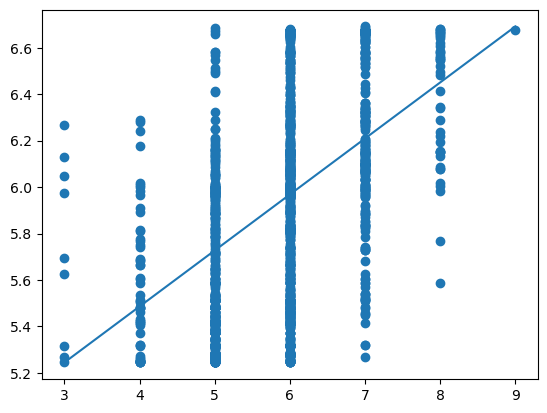

In [143]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(y_test_reg, y_pred_test_quality_rf_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_pred_train_quality_rf_reg.min(), y_pred_train_quality_rf_reg.max()])
plt.show()

In [145]:
mask_quality_modelos_clasificación_rendimiento

DecisionTreeClassifierOpt    False
LogisticRegressionOpt        False
RandomForestClassifierOpt    False
XGBClassifierOpt              True
dtype: bool

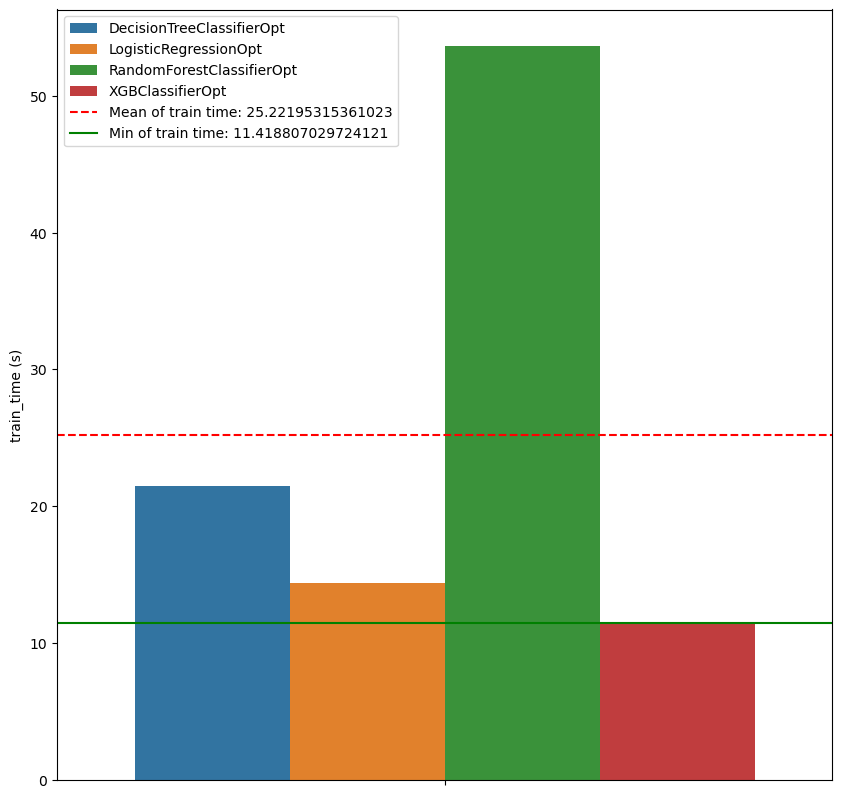

In [146]:
train_time_mean = quality_modelos_clasificacion_rendimiento['train_time (s)'].mean()
train_time_min = quality_modelos_clasificacion_rendimiento['train_time (s)'].min()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='train_time (s)', data=quality_modelos_clasificacion_rendimiento, ax=ax, hue=quality_modelos_clasificacion_rendimiento.index)
ax.axhline(train_time_mean, label=f'Mean of train time: {train_time_mean}', c='red', linestyle='--')
ax.axhline(train_time_min, label=f'Min of train time: {train_time_min}', c='green', linestyle='-')
ax.legend()

plt.show()

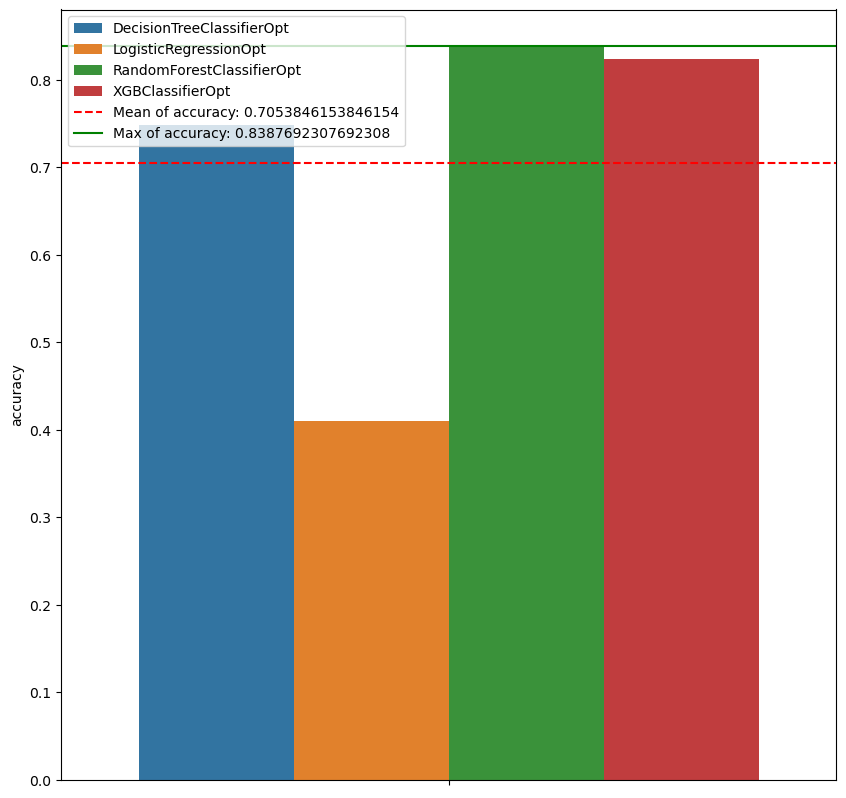

In [148]:
accuracy_mean = quality_modelos_clasificacion_rendimiento['accuracy'].mean()
accuracy_max = quality_modelos_clasificacion_rendimiento['accuracy'].max()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

sns.barplot(y='accuracy', data=quality_modelos_clasificacion_rendimiento, ax=ax, hue=quality_modelos_clasificacion_rendimiento.index)
ax.axhline(accuracy_mean, label=f'Mean of accuracy: {accuracy_mean}', c='red', linestyle='--')
ax.axhline(accuracy_max, label=f'Max of accuracy: {accuracy_max}', c='green', linestyle='-')

ax.legend()
plt.show()

In [ ]:
mask_quality_modelos_clasificación_rendimiento = (
    (quality_modelos_clasificacion_rendimiento['f1_weighted'] >= quality_modelos_clasificacion_rendimiento['f1_weighted'].quantile(0.60)) &
    (quality_modelos_clasificacion_rendimiento['accuracy'] >= quality_modelos_clasificacion_rendimiento['accuracy'].quantile(0.60)) &
    (quality_modelos_clasificacion_rendimiento['train_time (s)'] < quality_modelos_clasificacion_rendimiento['train_time (s)'].quantile(0.50))
)

quality_modelos_clasificacion_rendimiento_filtrado = quality_modelos_clasificacion_rendimiento[mask_quality_modelos_clasificación_rendimiento]
quality_modelos_clasificacion_rendimiento_filtrado

,train_time (s),f1_weighted,accuracy
XGBClassifierOpt,11.418807,0.823482,0.824


In [ ]:
row_index = 'XGBClassifierOpt'

# Aplicar estilo
quality_modelos_clasificacion_rendimiento.style.apply(highlight_best, axis=1, row_index=row_index)

,train_time (s),f1_weighted,accuracy
DecisionTreeClassifierOpt,21.459401,0.750004,0.748308
LogisticRegressionOpt,14.369754,0.340205,0.410462
RandomForestClassifierOpt,53.639851,0.836471,0.838769
XGBClassifierOpt,11.418807,0.823482,0.824000


### Conclusión de la Tarea de Regresión

**Escriban su conclusión aquí.**
*¿Qué modelo tuvo el mejor rendimiento? ¿Qué significan los valores de MAE y R² que obtuvieron? ¿La predicción de la calidad es una tarea fácil o difícil para estos modelos? Justifiquen su respuesta basándose en las métricas y el gráfico.*

<font color='green'>Respuesta:</font>

El modelo de regresión que mostró el mejor rendimiento para predecir la calidad del vino fue el árbol de decisión. Sin embargo, su desempeño fue limitado (con un valor de R^2 considerablemente inferior a 0.5), lo que indica una baja capacidad predictiva.
Debido a estos resultados, se decidió no continuar con la optimización de hiperparámetros en el enfoque de regresión y, en su lugar, discretizar la variable objetivo para transformar el problema en una tarea de clasificación binaria con dos posibles categorías: `'good_quality'` y `'bad_quality'`.

En este nuevo contexto supervisado, el modelo que obtuvo el mejor desempeño global fue el `XGBClassifier` optimizado, con los siguientes resultados:
- Tiempo de entrenamiento: 11.42 segundos
- F1-score ponderado: 0.8235
- Accuracy: 0.8240

<a name="final"></a>
## 6. (A COMPLETAR) Conclusiones Finales del Proyecto

En esta sección final, deben resumir los hallazgos de todo el proyecto.
* ¿Qué tarea fue más "fácil" para los modelos: clasificar el tipo de vino o predecir su calidad? ¿Por qué creen que fue así?
* ¿Qué importancia tuvo el preprocesamiento (escalado de datos)?
* ¿Valió la pena utilizar `GridSearchCV`? ¿Mejoró significativamente el rendimiento de los modelos base?
* Si tuvieran que presentarle una solución a la bodega, ¿qué modelos recomendarían para cada tarea y por qué?

<font color='green'>Respuesta:</font>

En términos generales, resultó más sencillo predecir el tipo de vino que su calidad. Esto se debe a que el tipo de vino (por ejemplo, blanco o tinto) es una característica más directamente relacionada con las propiedades fisicoquímicas medidas en las variables predictoras, las cuales permiten distinguir con gran facilidad entre ambas categorías.

Por el contrario, la calidad del vino es una variable más subjetiva y compleja, ya que no depende únicamente de las propiedades químicas u objetivas del producto. Factores como estrategias de mercadeo o aspectos contextuales pueden influir en la percepción de calidad, lo que dificulta su predicción precisa mediante modelos puramente fisicoquímicos.

El escalado de los datos demostró ser un paso relevante para los modelos lineales, como Logistic Regression o Linear Regression, ya que estos algoritmos son sensibles a las magnitudes de las variables y pueden mejorar su rendimiento cuando las características se encuentran en escalas comparables.

Sin embargo, como era de esperarse, esta ventaja no se manifestó en los modelos basados en árboles de decisión, los cuales no dependen de la escala de las variables, sino que se basan en criterios de partición o rangos (bins) para dividir el espacio de datos y modelar relaciones no lineales.

Aunque no se aplicó el enfoque en los modelos de regresión debido a su bajo desempeño inicial, el uso de GridSearchCV en los modelos de clasificación permitió observar mejoras moderadas en el rendimiento, especialmente en aquellos casos donde el modelo base ya mostraba un desempeño aceptable. Esto sugiere que, si bien la optimización de hiperparámetros puede aportar un ajuste fino, su impacto es limitado cuando naturalmente hay algunos datos atípicos entre las clases.

En ambas tareas —predecir el tipo de vino y predecir la calidad del vino— se asume un contexto de aplicación práctica, como podría ser identificar el tipo de vino en una etapa intermedia del proceso de producción o estimar su calidad en la fase final.
En estos escenarios, se busca lograr un alto rendimiento predictivo sin sacrificar eficiencia computacional, especialmente considerando la posibilidad de que el volumen de datos crezca y sea necesario reentrenar periódicamente los modelos.

Por este motivo, en ambas tareas se priorizó un equilibrio entre precisión y tiempo de entrenamiento, haciendo mas enfacis en la primera:
- **Predicción del tipo de vino:** el modelo XGBClassifier en su configuración base ofreció un desempeño sólido y consistente, tal como se detalla en su respectivo análisis.
- **Predicción de la calidad del vino:** el modelo XGBClassifier optimizado mediante GridSearchCV mostró una mejora significativa en las métricas, justificando su elección como el mejor modelo para esta tarea.